In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from collections import defaultdict

from surprise.model_selection import KFold

from surprise.model_selection.validation  import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans

import os
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

from surprise.model_selection import train_test_split

from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score
from collections import defaultdict

from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD

import seaborn as sns

import csv
import re


In [2]:
bike_data = pd.read_csv('../input/day.csv')

bike_data


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [3]:
video_data = pd.read_csv('../input/transcoding_mesurment.tsv', sep='\t')
video_data

,id,duration,codec,width,height,bitrate,framerate,i,p,b,...,p_size,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.000000,27,1537,0,...,825054,0,889537,mpeg4,56000,12.00,176,144,22508,0.612
1,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.000000,27,1537,0,...,825054,0,889537,mpeg4,56000,12.00,320,240,25164,0.980
2,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.000000,27,1537,0,...,825054,0,889537,mpeg4,56000,12.00,480,360,29228,1.216
3,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.000000,27,1537,0,...,825054,0,889537,mpeg4,56000,12.00,640,480,34316,1.692
4,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.000000,27,1537,0,...,825054,0,889537,mpeg4,56000,12.00,1280,720,58528,3.456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68779,ZWEN-71BqPs,972.27100,h264,480,360,278822,29.000000,560,28580,0,...,26561730,0,33886358,flv,242000,24.00,640,480,88692,1.552
68780,zWQN-bqqg0o,129.88100,vp8,640,480,639331,30.162790,36,3855,0,...,9503846,0,10379630,mpeg4,539000,29.97,1920,1080,107524,18.557
68781,zX17-vi0sqQ,249.68000,vp8,320,240,359345,25.068274,129,6113,0,...,9456514,0,11215178,flv,539000,12.00,176,144,88708,0.752
68782,zyiT-TzxIpk,183.62334,h264,1280,720,2847539,29.000000,98,5405,0,...,60113035,0,65359329,mpeg4,539000,12.00,320,240,88724,5.444


Bike Data List of absolute correlation with casual: 
casual        1.000000
cnt           0.672804
atemp         0.543864
temp          0.543285
workingday    0.518044
registered    0.395282
instant       0.275255
yr            0.248546
weathersit    0.247353
season        0.210399
windspeed     0.167613
mnth          0.123006
hum           0.077008
weekday       0.059923
holiday       0.054274
Name: casual, dtype: float64
Bike Data List of absolute correlation with registered: 
registered    1.000000
cnt           0.945517
instant       0.659623
yr            0.594248
atemp         0.544192
temp          0.540012
season        0.411623
casual        0.395282
workingday    0.303907
mnth          0.293488
weathersit    0.260388
windspeed     0.217449
holiday       0.108745
hum           0.091089
weekday       0.057367
Name: registered, dtype: float64
Bike Data List of absolute correlation with count: 
cnt           1.000000
registered    0.945517
casual        0.672804
atemp         0.6

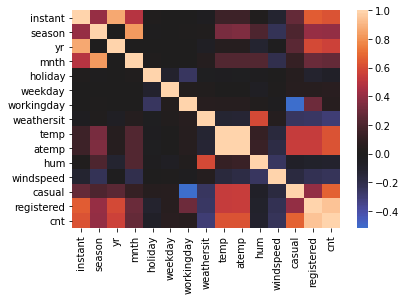

In [4]:
#question 1 heatmaps
#pandas dataframe.corr


bike_data_df = pd.DataFrame(data=bike_data)
video_data_df = pd.DataFrame(data=video_data)

bike_data_pearson = bike_data.corr(method='pearson', min_periods=1)
sns.heatmap(bike_data_pearson, center=0)

bike_pearson_abs = abs(bike_data_pearson)

#target variables - casual, registered, cnt

sorted_casual = bike_pearson_abs.casual.sort_values(ascending=False)
sorted_registered = bike_pearson_abs.registered.sort_values(ascending=False)
sorted_count = bike_pearson_abs.cnt.sort_values(ascending=False)


print("Bike Data List of absolute correlation with casual: \n" + str(sorted_casual))
print("Bike Data List of absolute correlation with registered: \n" + str(sorted_registered))
print("Bike Data List of absolute correlation with count: \n" + str(sorted_count))

Video Data List of absolute correlation with utime: 
utime          1.000000
umem           0.663301
o_width        0.523388
o_height       0.519649
o_bitrate      0.155479
bitrate        0.155200
width          0.129861
height         0.128479
o_framerate    0.104043
p_size         0.097644
size           0.097096
framerate      0.079336
i_size         0.064711
p              0.033201
frames         0.033115
i              0.018489
duration       0.005533
b              0.005140
b_size              NaN
Name: utime, dtype: float64


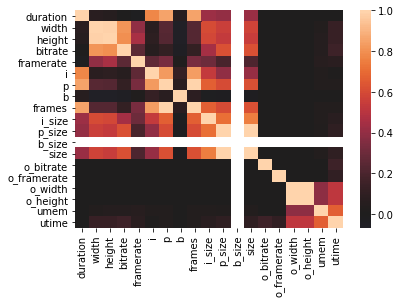

In [5]:
video_data_pearson = video_data.corr(method='pearson', min_periods=1)
video_pearson_abs = abs(video_data_pearson)
sns.heatmap(video_data_pearson, center=0)

#target variable is transcoding time "utime"

sorted_utime = video_pearson_abs.utime.sort_values(ascending=False)

print("Video Data List of absolute correlation with utime: \n" + str(sorted_utime))


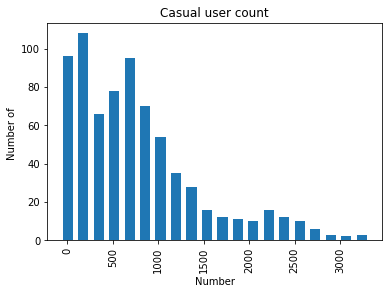

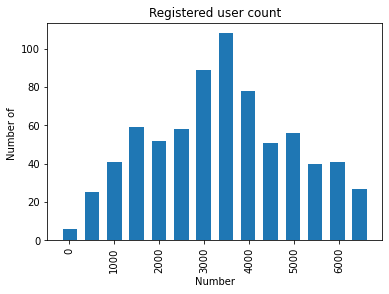

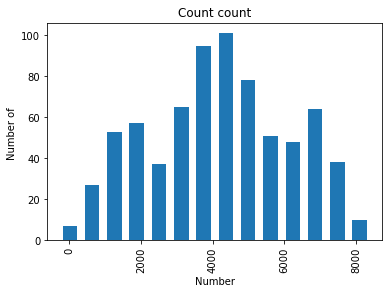

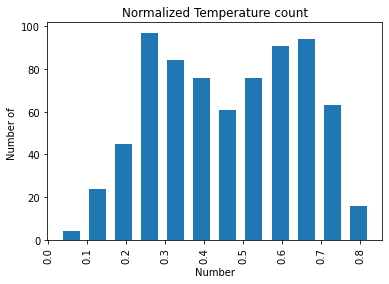

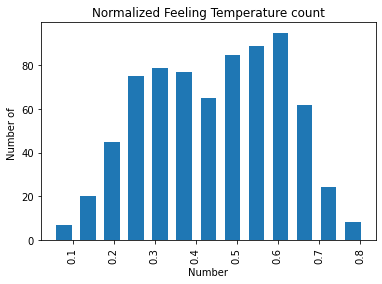

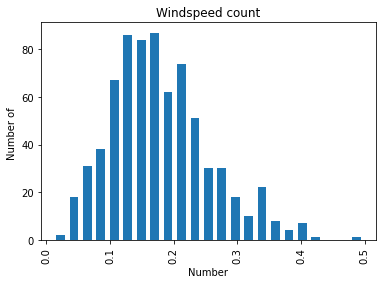

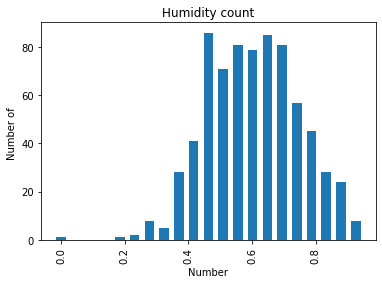

In [6]:
#question 2 plot histograms

plt.title("Casual user count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.casual, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Registered user count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.registered, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Count count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.cnt, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Normalized Temperature count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.temp, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Normalized Feeling Temperature count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.atemp, bins='auto', align='left', rwidth=0.65)

plt.show()


plt.title("Windspeed count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.windspeed, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Humidity count")
#Humidity "frequency?"
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(bike_data.hum, bins='auto', align='left', rwidth=0.65)

plt.show()


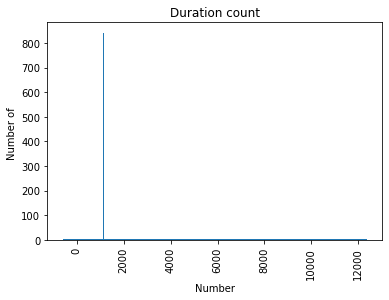

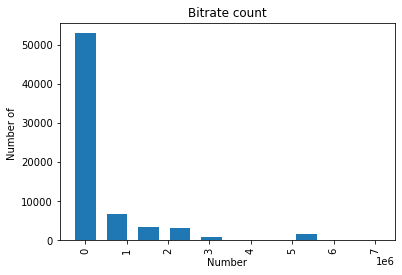

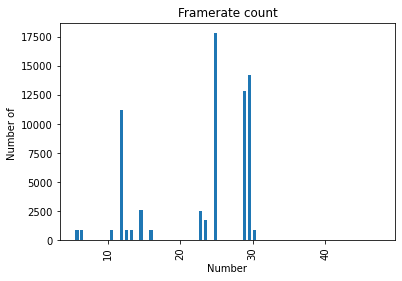

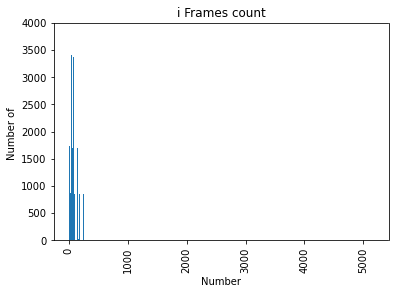

In [7]:
#question 2 continued - video dataset

#everything except codec, height, width, o-height, o-width?

unique_duration = np.unique(video_data.duration)

plt.title("Duration count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")

plt.hist(video_data.duration, bins=unique_duration, align='left', rwidth=0.65)

plt.show()


unique_bitrate = np.unique(video_data.bitrate)
append = np.ndarray.tolist(unique_bitrate)
append_to = append.append(max(append) + 1)

plt.title("Bitrate count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.bitrate, bins=append_to, align='left', rwidth=0.65)

plt.show()



plt.title("Framerate count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.framerate, bins='auto', align='left', rwidth=0.65)

plt.show()



plt.title("i Frames count")
plt.xticks(rotation='vertical')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,4000])
plt.hist(video_data.i, bins='auto', align='left', rwidth=0.65)

plt.show()

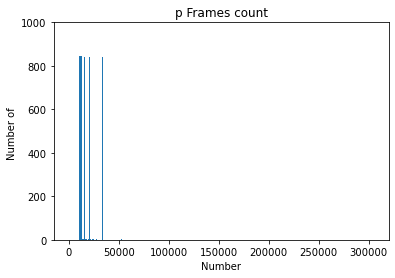

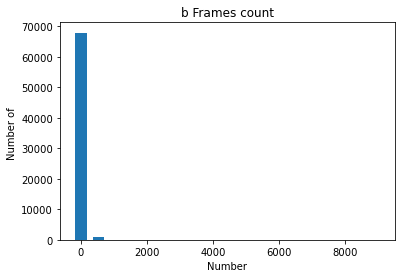

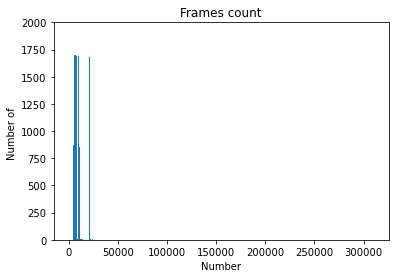

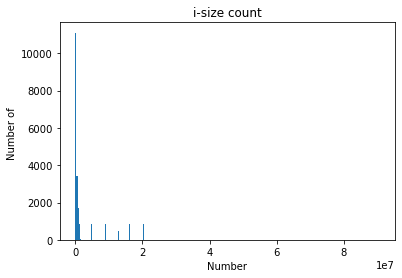

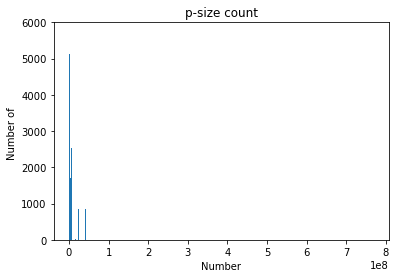

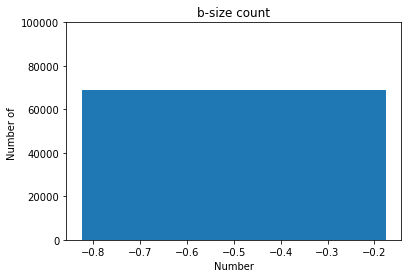

In [8]:
#video data continued



plt.title("p Frames count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,1000])
plt.hist(video_data.p, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("b Frames count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.b, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("Frames count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,2000])
plt.hist(video_data.frames, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("i-size count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
#plt.ylim([0,1000])
plt.hist(video_data.i_size, bins='auto', align='left', rwidth=0.65)

plt.show()


plt.title("p-size count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,6000])
plt.hist(video_data.p_size, bins='auto', align='left', rwidth=0.65)

plt.show()



plt.title("b-size count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,100000])
plt.hist(video_data.b_size, bins='auto', align='left', rwidth=0.65)

plt.show()



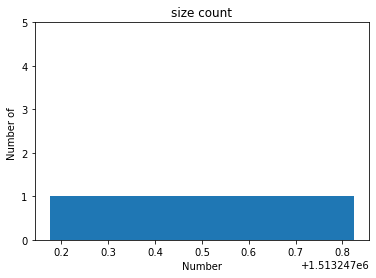

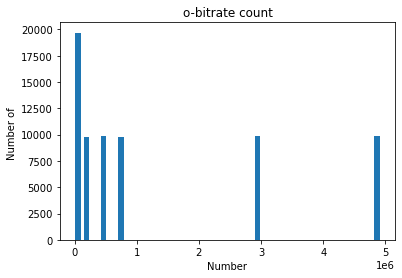

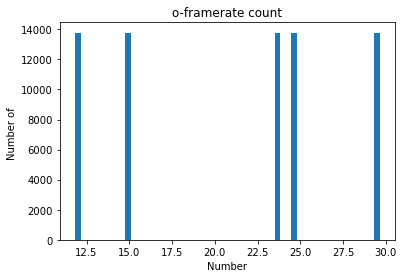

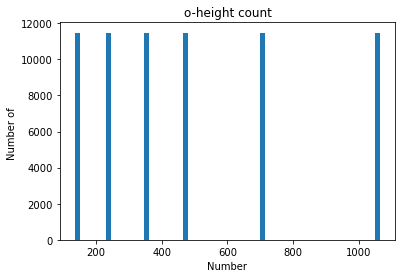

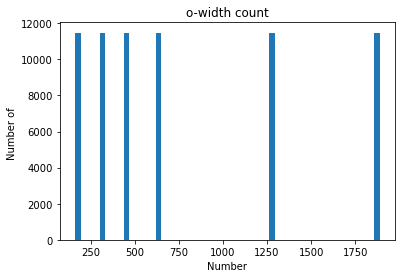

In [9]:
# video data continued 

plt.title("size count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.ylim([0,5])
plt.hist(video_data.size, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("o-bitrate count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.o_bitrate, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("o-framerate count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.o_framerate, bins='auto', align='left', rwidth=0.65)

plt.show()

plt.title("o-height count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.o_height, bins='auto', align='left', rwidth=0.65)

plt.show()


plt.title("o-width count")
plt.xticks(rotation='horizontal')
plt.xlabel("Number")
plt.ylabel("Number of ")
plt.hist(video_data.o_width, bins='auto', align='left', rwidth=0.65)

plt.show()



In [10]:
unique_p = np.unique(video_data.p)
print(unique_p)
unique_b = np.unique(video_data.b)
print(unique_b)

[   175    248    274 ...  91758 173123 304959]
[   0    6   42  184  316  626  674  704  891 1007 1251 1539 1965 1996
 2025 2416 2626 3385 6806 9407]


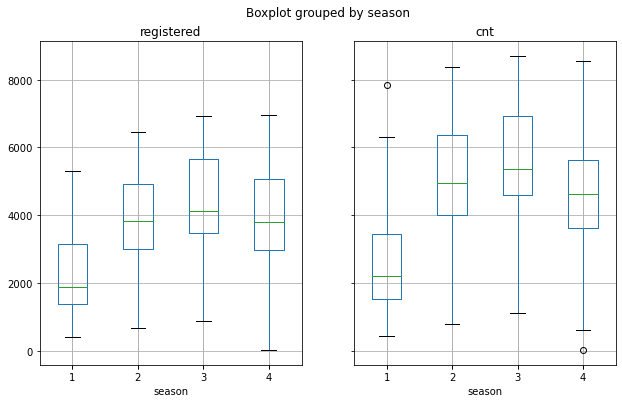

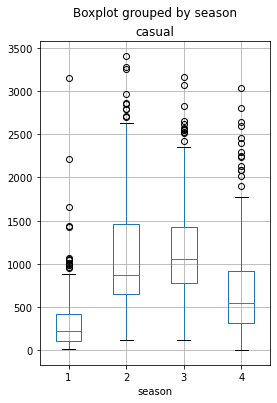

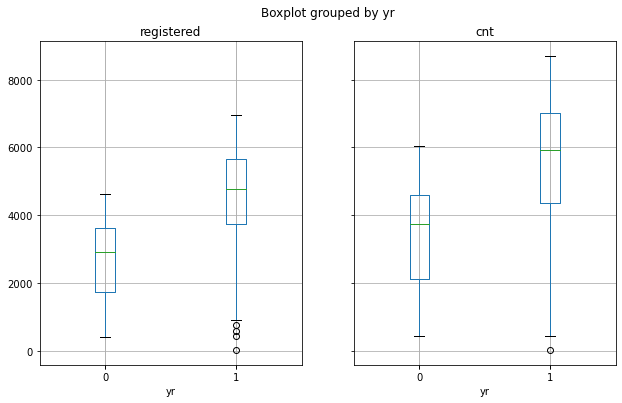

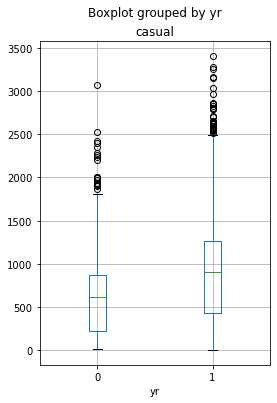

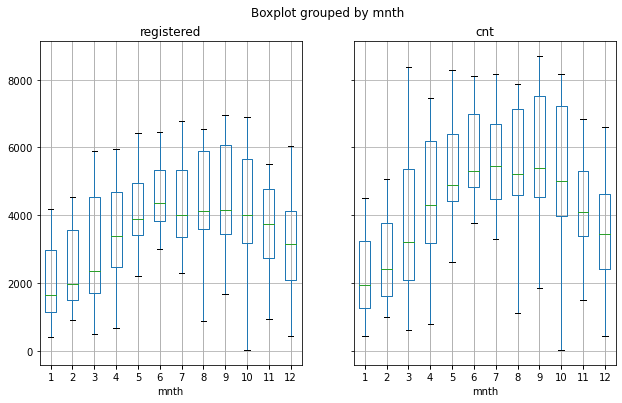

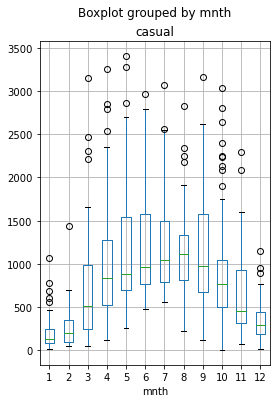

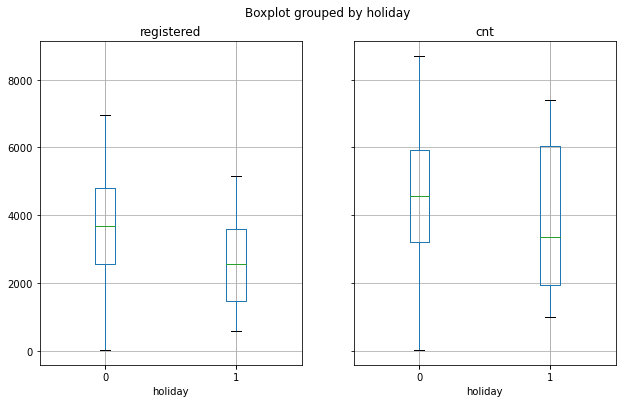

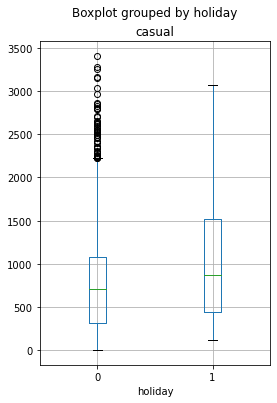

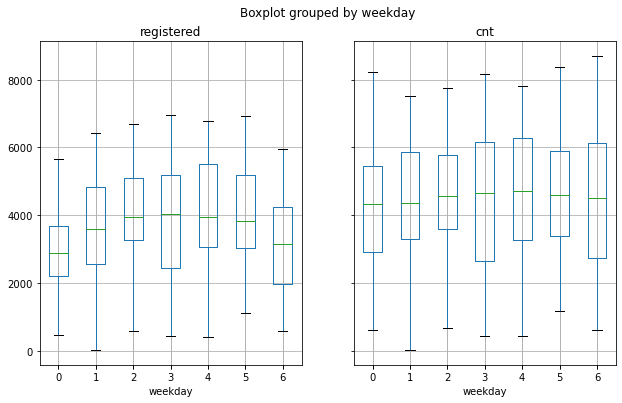

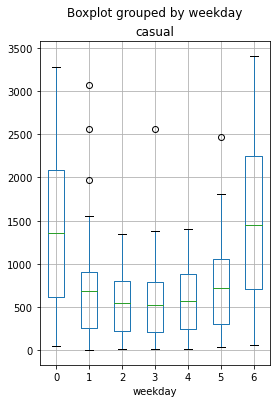

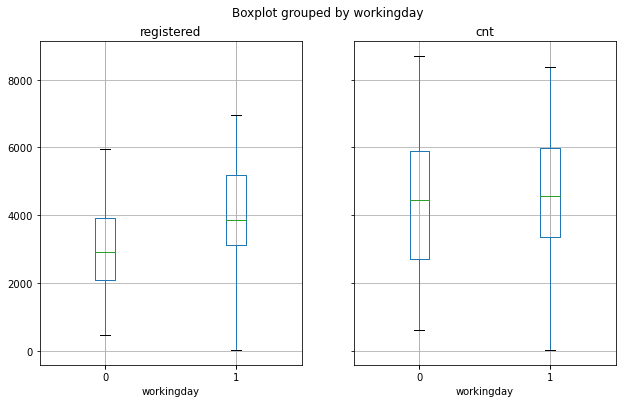

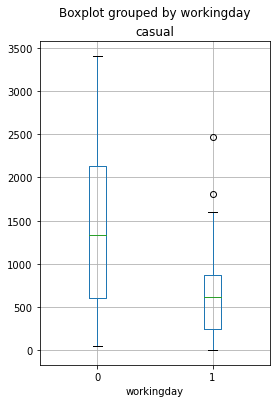

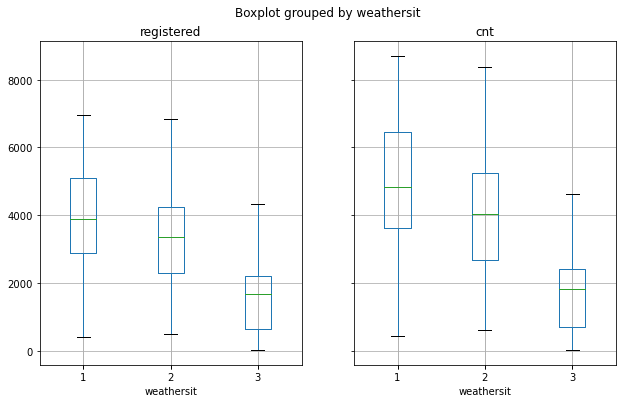

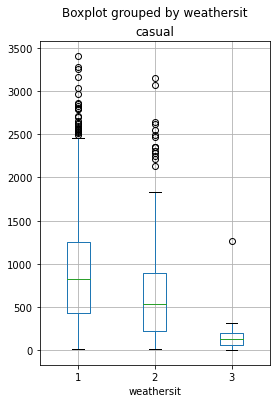

In [11]:
# question 3 box plots of categorical features vs target variable

#bike_data_df.boxplot(column=['casual', 'registered', 'cnt'], by='instant', figsize=(12,8))
#plt.show()

#bike_data_df.boxplot(column=['casual', 'registered', 'cnt'], by='dteday', figsize=(12,8))
#plt.show()

# casual is plotted separately because registered and cnt numbers are much higher than casual

#fig, ax = plt.subplots(figsize=(12,8))

bike_data_figsize = (10,6)
casual_figsize = (4,6)
bike_data_df.boxplot(column=['registered', 'cnt'], by='season', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='season', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='yr', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='yr', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='mnth', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='mnth', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='holiday', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='holiday', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='weekday', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='weekday', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='workingday', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='workingday', figsize=casual_figsize)
plt.show()

bike_data_df.boxplot(column=['registered', 'cnt'], by='weathersit', figsize=bike_data_figsize)
plt.show()

bike_data_df.boxplot(column=['casual'], by='weathersit', figsize=casual_figsize)
plt.show()


#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html




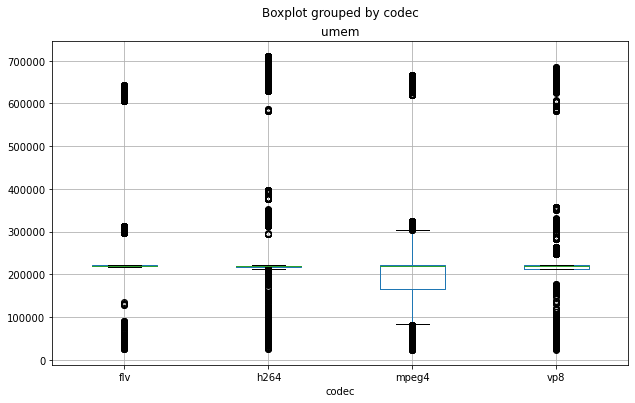

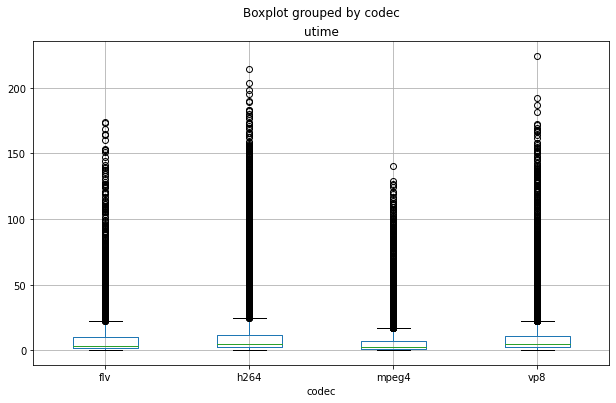

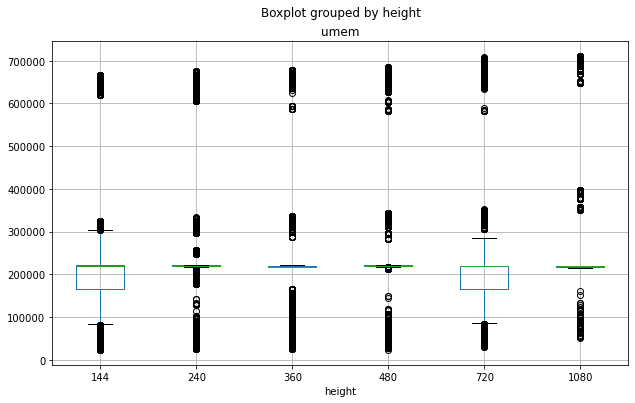

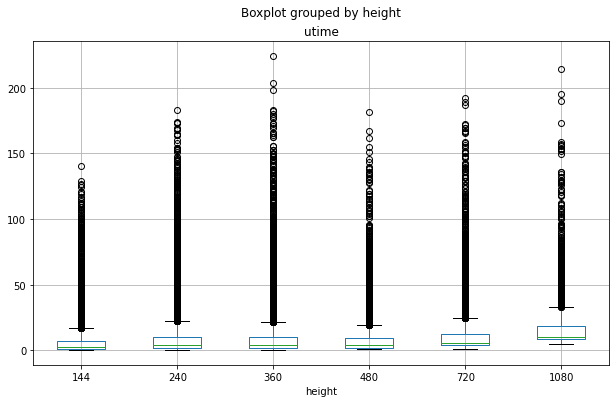

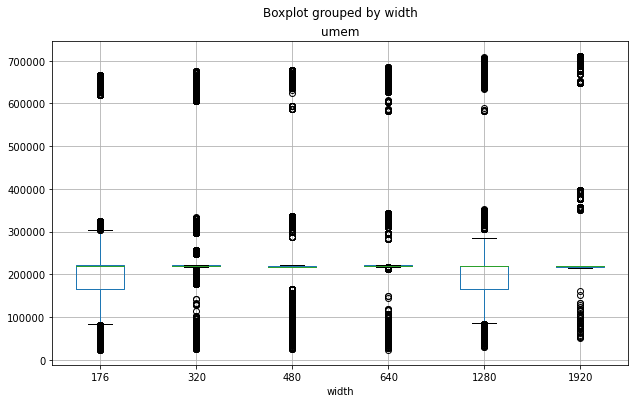

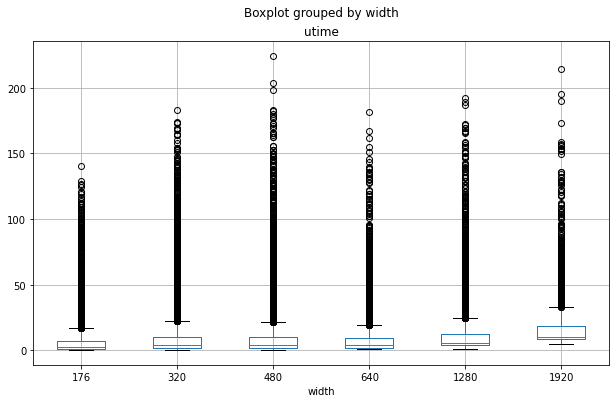

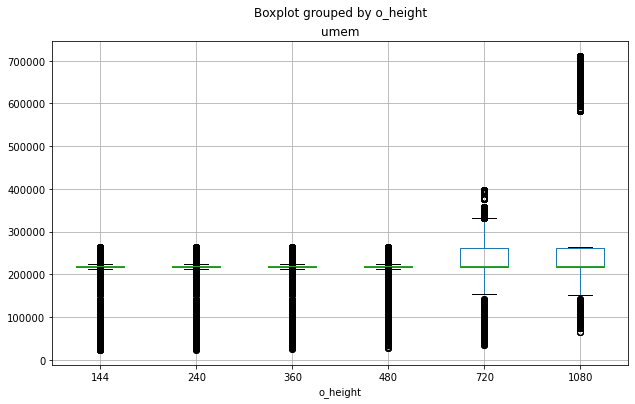

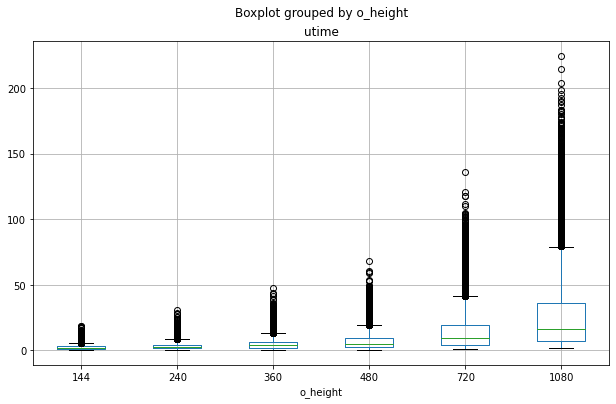

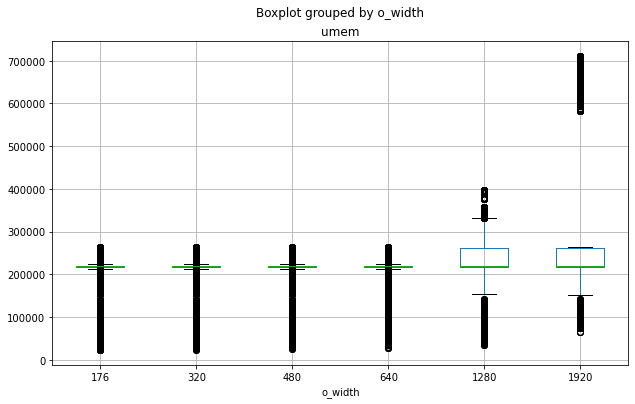

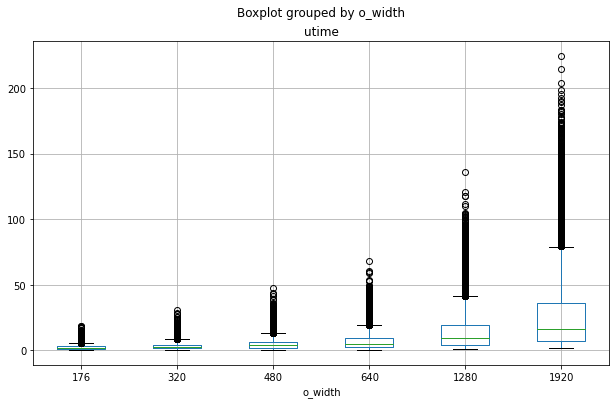

In [12]:
# question 3 continued - video data

video_data_figsize = (10,6)
#casual_figsize = (4,6)

video_data_df.boxplot(column=['umem'], by='codec', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['utime'], by='codec', figsize=video_data_figsize)
plt.show()

#everything except codec, height, width, o-height, o-width?

video_data_df.boxplot(column=['umem'], by='height', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['utime'], by='height', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['umem'], by='width', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['utime'], by='width', figsize=video_data_figsize)
plt.show()


video_data_df.boxplot(column=['umem'], by='o_height', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['utime'], by='o_height', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['umem'], by='o_width', figsize=video_data_figsize)
plt.show()

video_data_df.boxplot(column=['utime'], by='o_width', figsize=video_data_figsize)
plt.show()

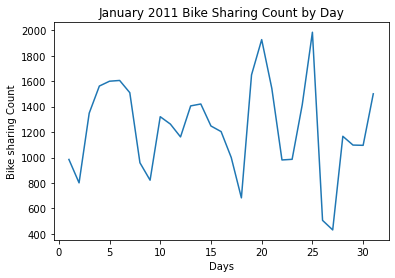

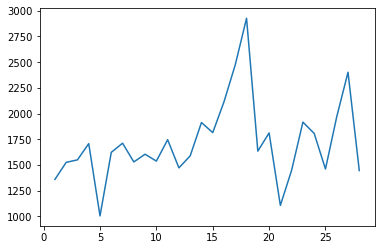

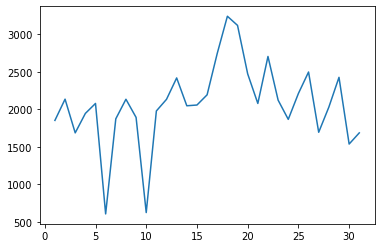

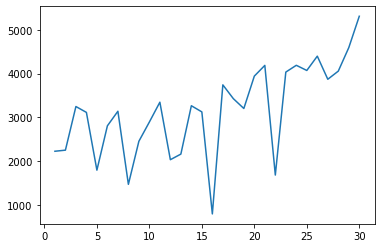

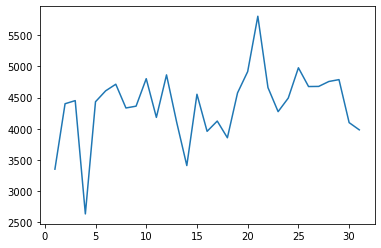

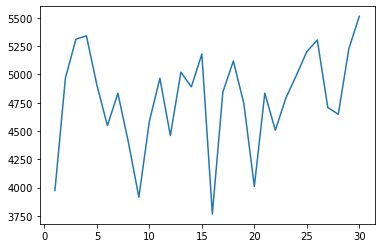

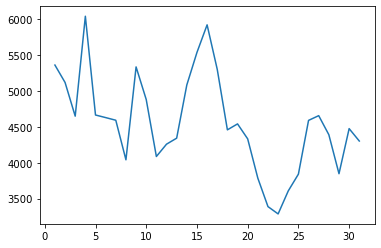

In [13]:
#question 4 bike sharing


#plot count number per day for a few months
month_range = pd.date_range('1/1/2011', periods=12)

jan_plot = []
feb_plot = []
mar_plot = []
apr_plot = []
may_plot = []
jun_plot = []
jul_plot = []

bike_date_jan = bike_data_df[['dteday','cnt']][:31]
bike_date_feb = bike_data_df[['dteday', 'cnt']][31:59]
bike_date_mar = bike_data_df[['dteday', 'cnt']][59:90]
bike_date_apr = bike_data_df[['dteday', 'cnt']][90:120]
bike_date_may = bike_data_df[['dteday', 'cnt']][120:151]
bike_date_jun = bike_data_df[['dteday', 'cnt']][151:181]
bike_date_jul = bike_data_df[['dteday', 'cnt']][181:212]

#print(bike_date_may)


for index, row in bike_date_jan.iterrows():
    #print(row['dteday'], row['cnt'])
    jan_plot.append(row['cnt'])

for index, row in bike_date_feb.iterrows():
    feb_plot.append(row['cnt'])

for index, row in bike_date_mar.iterrows():
    mar_plot.append(row['cnt'])

for index, row in bike_date_apr.iterrows():
    apr_plot.append(row['cnt'])
    
for index, row in bike_date_may.iterrows():
    may_plot.append(row['cnt'])

for index, row in bike_date_jun.iterrows():
    jun_plot.append(row['cnt'])

for index, row in bike_date_jul.iterrows():
    jul_plot.append(row['cnt'])


jan_axis = range(1,32,1)
feb_axis = range(1,29,1)
mar_axis = range(1,32,1)
apr_axis = range(1,31,1)
may_axis = range(1,32,1)
jun_axis = range(1,31,1)
jul_axis = range(1,32,1)

plt.plot(jan_axis, jan_plot)
plt.xlabel("Days")
plt.ylabel("Bike sharing Count")
plt.title("January 2011 Bike Sharing Count by Day")
plt.show()

plt.plot(feb_axis, feb_plot)
plt.show()

plt.plot(mar_axis, mar_plot)
plt.show()

plt.plot(apr_axis, apr_plot)
plt.show()

plt.plot(may_axis, may_plot)
plt.show()

plt.plot(jun_axis, jun_plot)
plt.show()

plt.plot(jul_axis, jul_plot)
plt.show()

0         0.612
1         0.980
2         1.216
3         1.692
4         3.456
          ...  
68779     1.552
68780    18.557
68781     0.752
68782     5.444
68783     3.076
Name: utime, Length: 68784, dtype: float64
Mean transcoding time: 9.996354820888516
Median transcoding time: 4.408


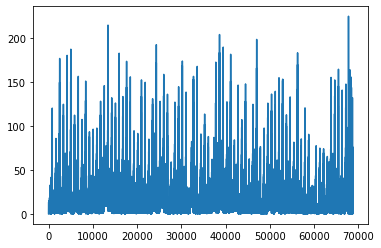

In [14]:
#question 5 utime plot, mean, median


utime_all = video_data_df['utime']

print(utime_all)

utime_axis = range(0,len(video_data_df.index))
plt.plot(utime_axis, utime_all)

print("Mean transcoding time: " +str(np.mean(utime_all)))

print("Median transcoding time: " +str(np.median(utime_all)))


In [15]:
#question 6 - theoretical

In [16]:
# question 7 standardization

#center the data to have 0 mean and unit variance


#example below from
#https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)


#########################################################
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

NameError: name 'X_train' is not defined

In [17]:
#running comment